# Coding Project: Reproducing Salehi et al. with Transformers instead of VGG

### Installing packages

In [2]:
!git clone https://github.com/LucStrater/Knowledge_Distillation_AD.git
%cd /content/Knowledge_Distillation_AD

Cloning into 'Knowledge_Distillation_AD'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 146 (delta 58), reused 85 (delta 39), pack-reused 30
Receiving objects: 100% (146/146), 19.88 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/Knowledge_Distillation_AD


In [3]:
# standard
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
import requests

# plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# tqdm for loading bars
from tqdm.notebook import tqdm

# eval
from sklearn.metrics import roc_curve, auc

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Huggingface transformers
try:
    from transformers import ViTImageProcessor, ViTForImageClassification
except ModuleNotFoundError:
    !pip install --quiet transformers
    from transformers import ViTImageProcessor, ViTForImageClassification

# tensorboard
%load_ext tensorboard

# paths
cwd = os.getcwd()
DATASET_PATH = f"{cwd}/data"
os.makedirs(DATASET_PATH, exist_ok=True)
CHECKPOINT_PATH = f"{cwd}/outputs/vit_checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# seeding
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-3-82f1351e9609>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.6 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

### Load data

Wrote my own dataloader as the original dataloader could not be used with pretrained ViT's because they all have patch sizes of 16x16 and the images are only 32x32. I found a pretrained ViT on huggingface that was already fine tuned on CIFAR10 which I want to use and therefor I need to rescale CIFAR10 to 224x224. Also the initial code base had that the validation set and test set were the same thing and also did not include shuffling.

In [78]:
def prepare_cifar10_data_loaders(image_mean, image_std, size, batch_size, path, num_workers, seed):
    normalize = transforms.Normalize(mean=image_mean, std=image_std)

    test_transform = transforms.Compose([transforms.Resize(size),
                                         transforms.ToTensor(),
                                         normalize
                                        ])
    train_transform = transforms.Compose([transforms.RandomResizedCrop(size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          normalize
                                        ])

    # load dataset
    train_dataset = CIFAR10(root=path, train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root=path, train=True, transform=test_transform, download=True)
    pl.seed_everything(seed)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    pl.seed_everything(seed)
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root=path, train=False, transform=test_transform, download=True)

    # data loaders
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

Files already downloaded and verified
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


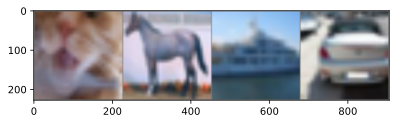

In [85]:
processor_pretrained = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
image_mean = processor_pretrained.image_mean
image_std = processor_pretrained.image_std
size = processor_pretrained.size["height"]

train_loader, val_loader, test_loader = prepare_cifar10_data_loaders(image_mean=image_mean, image_std=image_std, size=size, batch_size=4, path=DATASET_PATH, num_workers=2, seed=42)

dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

### Understanding Huggingface pretrained ViTs

This chapter is just to see how to use Hugginface pretrained ViT works.

In [86]:
vit_pretrained = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', output_hidden_states=True)

# preprocess
inputs = processor_pretrained(images=images, do_resize=False, do_rescale=False, do_normalize=False, return_tensors="pt")

# inference
with torch.no_grad():
    outputs = vit_pretrained(**inputs)

# predicted class
preds = outputs.logits.argmax(dim=1)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
predicted_class = []
for i in range(preds.shape[0]):
  predicted_class.append(classes[preds[i].item()])

print(predicted_class)

['cat', 'horse', 'ship', 'automobile']


In [76]:
print(outputs.hidden_states[12].shape)

torch.Size([4, 197, 768])


In [82]:
vit_pretrained

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Helper functions

For the smaller distilled model that has to be trained I use the set up that I found in this [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html) by Philip Lippe. Basicly it is a simple ViT implementation in pytorch lightning. I do not use the actual ViT class from the tutorial since it has another training objective, but I do use all the helper classes. For more information look at the tutorial itself. Furthermore I use the loss function from the original repository.

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [ ]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
class MseDirectionLoss(nn.Module):
    def __init__(self, lamda):
        super(MseDirectionLoss, self).__init__()
        self.lamda = lamda
        self.criterion = nn.MSELoss()
        self.similarity_loss = torch.nn.CosineSimilarity()

    def forward(self, output_pred, output_real):
        y_pred_0, y_pred_1, y_pred_2, y_pred_3 = output_pred[3], output_pred[6], output_pred[9], output_pred[12]
        y_0, y_1, y_2, y_3 = output_real[3], output_real[6], output_real[9], output_real[12]

        # different terms of loss
        abs_loss_0 = self.criterion(y_pred_0, y_0)
        loss_0 = torch.mean(1 - self.similarity_loss(y_pred_0.view(y_pred_0.shape[0], -1), y_0.view(y_0.shape[0], -1)))
        abs_loss_1 = self.criterion(y_pred_1, y_1)
        loss_1 = torch.mean(1 - self.similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1)))
        abs_loss_2 = self.criterion(y_pred_2, y_2)
        loss_2 = torch.mean(1 - self.similarity_loss(y_pred_2.view(y_pred_2.shape[0], -1), y_2.view(y_2.shape[0], -1)))
        abs_loss_3 = self.criterion(y_pred_3, y_3)
        loss_3 = torch.mean(1 - self.similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1)))

        total_loss = loss_0 + loss_1 + loss_2 + loss_3 + self.lamda * (
                abs_loss_0 + abs_loss_1 + abs_loss_2 + abs_loss_3)

        return total_loss

### ViT model

This is were the actual Knowledge Distillation for Anomaly Detection comes in. I decided to go for this pytorch lightning implementation so I needed to incorporate the MseDirectionLoss from the original code base here. The main idea is to use a ViT that is pretrained and fine-tuned on CIFAR10. Than to distill its capabilities into a smaller ViT that is trained here, the outputs of the hidden dimensions of multiple layers are forced to be similar to those of pretrained ViT.

In [ ]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr, lamda, normal_class):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)

        # get pretrained ViT
        self.processor_pretrained = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
        self.vit_pretrained = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', output_hidden_states=True)

        # loss function
        self.criterion = MseDirectionLoss(lamda)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _step(self, batch, mode="train"):
        images, _ = batch

        # inference
        output_pred = self.model(images)

        # inference pretrained model
        inputs = self.processor_pretrained(images=images, do_resize=False, do_rescale=False, do_normalize=False, return_tensors="pt")
        with torch.no_grad():
            output_real = self.vit_pretrained(**inputs)

        # loss
        loss = self.criterion(output_pred, output_real.hidden_states)
        self.log(f'{mode}_loss', loss)

        return loss

    def _eval_step(self, batch, mode="val"):
        loss = self._step(batch, mode=mode)

        _, labels = batch
        target_class = self.hparams.normal_class

        # prep roc auc
        scores = -loss.unsqueeze(dim=0)
        labels = torch.where(labels == target_class, 0, 1)  # 0 for normal_class, 1 for anomalies

        # We return the scores and labels for each batch
        return {'scores': scores, 'labels': labels}

    def _eval_epoch_end(self, outputs, mode="val"):
        # Concatenate all batches
        all_scores = torch.cat([x['scores'] for x in outputs], dim=0)
        all_labels = torch.cat([x['labels'] for x in outputs], dim=0)

        # Convert to numpy for sklearn
        scores_np = all_scores.view(-1).cpu().numpy()
        labels_np = all_labels.view(-1).cpu().numpy()

        # calculate ROC AUC
        fpr, tpr, thresholds = roc_curve(labels_np, scores_np, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_auc = round(roc_auc, 4)
        self.log(f'{mode}_roc_auc', roc_auc, on_epoch=True, prog_bar=True)

        # You can also return the ROC AUC score if you need it
        return {'test_roc_auc': roc_auc}

    def training_step(self, batch, batch_idx):
        loss = self._step(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        val_dict = self._eval_step(batch, mode="val")
        return val_dict

    def test_step(self, batch, batch_idx):
        test_dict = self._eval_step(batch, mode="test")
        return test_dict

    def validation_epoch_end(self, outputs):
        val_result = self._eval_epoch_end(self, outputs, mode="val")
        return val_result

    def test_epoch_end(self, outputs):
        test_result = self._eval_epoch_end(self, outputs, mode="test")
        return test_result



### Old stuff, for reference

In [ ]:
config = {}

# Data parameters
config["experiment_name"] = 'local_equal_net'
config["dataset_name"] = 'cifar10'
config["last_checkpoint"] = 200

# Training parameters
config["num_epochs"] = 1 # put 201 if you want to train from scratch
config["batch_size"] = 64
config["learning_rate"] = 1e-3
config["mvtec_img_size"] = 128
config["normal_class"] = 3
config["lamda"] = 0.01
config["pretrain"] = True # True =use pre-trained vgg as source network --- False =use random initialize
config["use_bias"] = False # True =using bias term in neural network layer
config["equal_network_size"] = False # True =using equal network size for cloner and source network --- False =smaller network for cloner
config["direction_loss_only"] = False
config["continue_train"] = True

# Test parameters
config["localization_test"] = False # True =For Localization Test --- False =For Detection
config["localization_method"] = 'gbp' # gradients , smooth_grad , gbp

In [ ]:
def test(model, vit_pretrained, processor_pretrained, test_dataloader, config):
    target_class = config["normal_class"]

    similarity_loss = torch.nn.CosineSimilarity()
    label_score = []
    model.eval()
    for data in test_dataloader:
        X, Y = data
        if X.shape[1] == 1:
            X = X.repeat(1, 3, 1, 1)
        X = Variable(X).cuda()

        # preprocess inputs for pretrained model
        inputs_pretrained = processor_pretrained(images=X, return_tensors="pt")

        # inference pretrained model
        with torch.no_grad():
            output_real = vit_pretrained(**inputs_pretrained).hidden_states

        output_pred = model.forward(X)

        y_pred_1, y_pred_2, y_pred_3 = output_pred[6], output_pred[9], output_pred[12]
        y_1, y_2, y_3 = output_real[6], output_real[9], output_real[12]

        abs_loss_1 = torch.mean((y_pred_1 - y_1) ** 2, dim=(1, 2, 3))
        loss_1 = 1 - similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1))
        abs_loss_2 = torch.mean((y_pred_2 - y_2) ** 2, dim=(1, 2, 3))
        loss_2 = 1 - similarity_loss(y_pred_2.view(y_pred_2.shape[0], -1), y_2.view(y_2.shape[0], -1))
        abs_loss_3 = torch.mean((y_pred_3 - y_3) ** 2, dim=(1, 2, 3))
        loss_3 = 1 - similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1))
        total_loss = loss_1 + loss_2 + loss_3 + config['lamda'] * (abs_loss_1 + abs_loss_2 + abs_loss_3)

        label_score += list(zip(Y.cpu().data.numpy().tolist(), total_loss.cpu().data.numpy().tolist()))

    labels, scores = zip(*label_score)
    labels = np.array(labels)
    indx1 = labels == target_class
    indx2 = labels != target_class
    labels[indx1] = 1
    labels[indx2] = 0
    scores = np.array(scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
    roc_auc = auc(fpr, tpr)
    roc_auc = round(roc_auc, 4)
    return roc_auc

In [ ]:
def train(config):
    # data prep
    train_dataloader, test_dataloader = load_data(config)

    # define model here above optimizer!

    # criteria / optimizers
    criterion = MseDirectionLoss(config["lamda"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    # get pretrained ViT
    processor_pretrained = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
    vit_pretrained = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', output_hidden_states=True)

    # init logging
    losses = []
    roc_aucs = []

    for epoch in range(config["num_epochs"] + 1):
        model.train()
        epoch_loss = 0
        for data in train_dataloader:
            X = data[0]
            if X.shape[1] == 1:
                X = X.repeat(1, 3, 1, 1)
            X = Variable(X).cuda()

            # preprocess inputs for pretrained model
            inputs_pretrained = processor_pretrained(images=X, return_tensors="pt")

            # inference pretrained model
            with torch.no_grad():
                output_real = vit_pretrained(**inputs_pretrained).hidden_states

            output_pred = model.forward(X)

            total_loss = criterion(output_pred, output_real)

            # logging
            epoch_loss += total_loss.item()
            losses.append(total_loss.item())

            # standard pytorch
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss))
        if epoch % 10 == 0:
            roc_auc = test(model, vit_pretrained, processor_pretrained, test_dataloader, config)
            roc_aucs.append(roc_auc)
            print("RocAUC at epoch {}:".format(epoch), roc_auc)

    return model, vit_pretrained, processor_pretrained

In [ ]:
set_seed(42)
model, vit_pretrained, processor_pretrained = train(config)

100%|██████████| 170498071/170498071 [00:01<00:00, 92568537.52it/s] 


Extracting ./Dataset/CIFAR10/train/cifar-10-python.tar.gz to ./Dataset/CIFAR10/train
Cifar10 DataLoader Called...
All Train Data:  (50000, 32, 32, 3)
Normal Train Data:  (5000, 32, 32, 3)


100%|██████████| 170498071/170498071 [00:02<00:00, 81135462.02it/s]


Extracting ./Dataset/CIFAR10/test/cifar-10-python.tar.gz to ./Dataset/CIFAR10/test
Test Train Data: (10000, 32, 32, 3)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


layer : 0 Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 1 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer : 2 ReLU(inplace=True)
layer : 3 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 4 ReLU(inplace=True)
layer : 5 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layer : 6 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 7 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer : 8 ReLU(inplace=True)
layer : 9 Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 10 ReLU(inplace=True)
layer : 11 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layer : 12 Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 13 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

KeyboardInterrupt: ignored

In [ ]:
# Detection test
_, test_dataloader = load_data(config)
roc_auc = test(model, vit_pretrained, processor_pretrained, test_dataloader, config)
last_checkpoint = config['last_checkpoint']
print("RocAUC after {} epoch:".format(last_checkpoint), roc_auc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]


layer : 0 Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 1 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer : 2 ReLU(inplace=True)
layer : 3 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 4 ReLU(inplace=True)
layer : 5 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layer : 6 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 7 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer : 8 ReLU(inplace=True)
layer : 9 Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 10 ReLU(inplace=True)
layer : 11 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layer : 12 Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer : 13 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

100%|██████████| 170498071/170498071 [00:08<00:00, 20973895.55it/s]


Extracting ./Dataset/CIFAR10/train/cifar-10-python.tar.gz to ./Dataset/CIFAR10/train
Cifar10 DataLoader Called...
All Train Data:  (50000, 32, 32, 3)
Normal Train Data:  (5000, 32, 32, 3)


100%|██████████| 170498071/170498071 [00:08<00:00, 20880714.93it/s]


Extracting ./Dataset/CIFAR10/test/cifar-10-python.tar.gz to ./Dataset/CIFAR10/test
Test Train Data: (10000, 32, 32, 3)
RocAUC after 200 epoch: 0.7703
